##Step 1: Preparing the Data
**Rationale**: Before any analysis, it's crucial to prepare and understand your data. This involves loading the data, converting date columns to datetime objects for easier manipulation, and sorting if necessary.

In [1]:
import pandas as pd

data = pd.read_csv('/content/Nat_Gas.csv')

#Convert 'Date' column to datetime
data['Dates'] = pd.to_datetime(data['Dates'])

#Sort data by date
data = data.sort_values(by='Dates')

<ipython-input-1-9c34247d2ed1>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Dates'] = pd.to_datetime(data['Dates'])


##Step 2: Visualizing Initial Data
**Rationale**: Visualization helps identify patterns, trends, or anomalies. Initial plotting can guide the modeling approach by revealing underlying structures in the data.



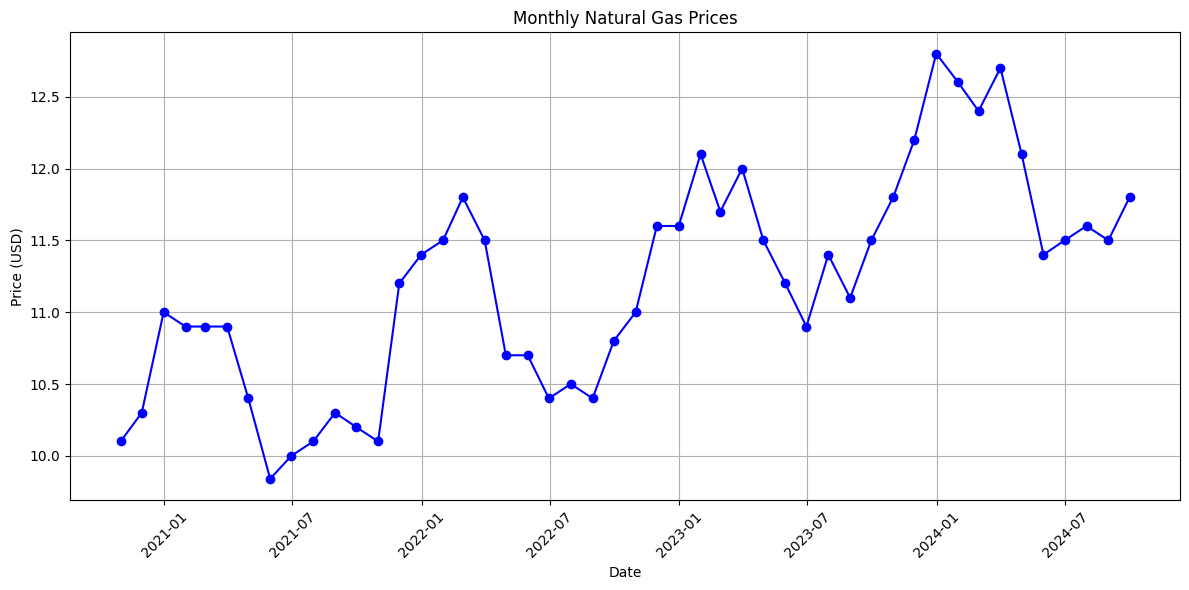

In [2]:
import matplotlib.pyplot as plt

# Plotting the prices against dates
plt.figure(figsize=(12, 6))
plt.plot(data['Dates'], data['Prices'], marker='o', linestyle='-', color='b')
plt.title('Monthly Natural Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The plot of monthly natural gas prices shows some fluctuations, which may indicate seasonal trends, especially visible in potential peaks during winter months. To confirm this and capture the seasonal effects more accurately, I will decompose the time series into trend, seasonal, and residual components. Then, I'll proceed with fitting a model that can be used for interpolation and extrapolation of prices.

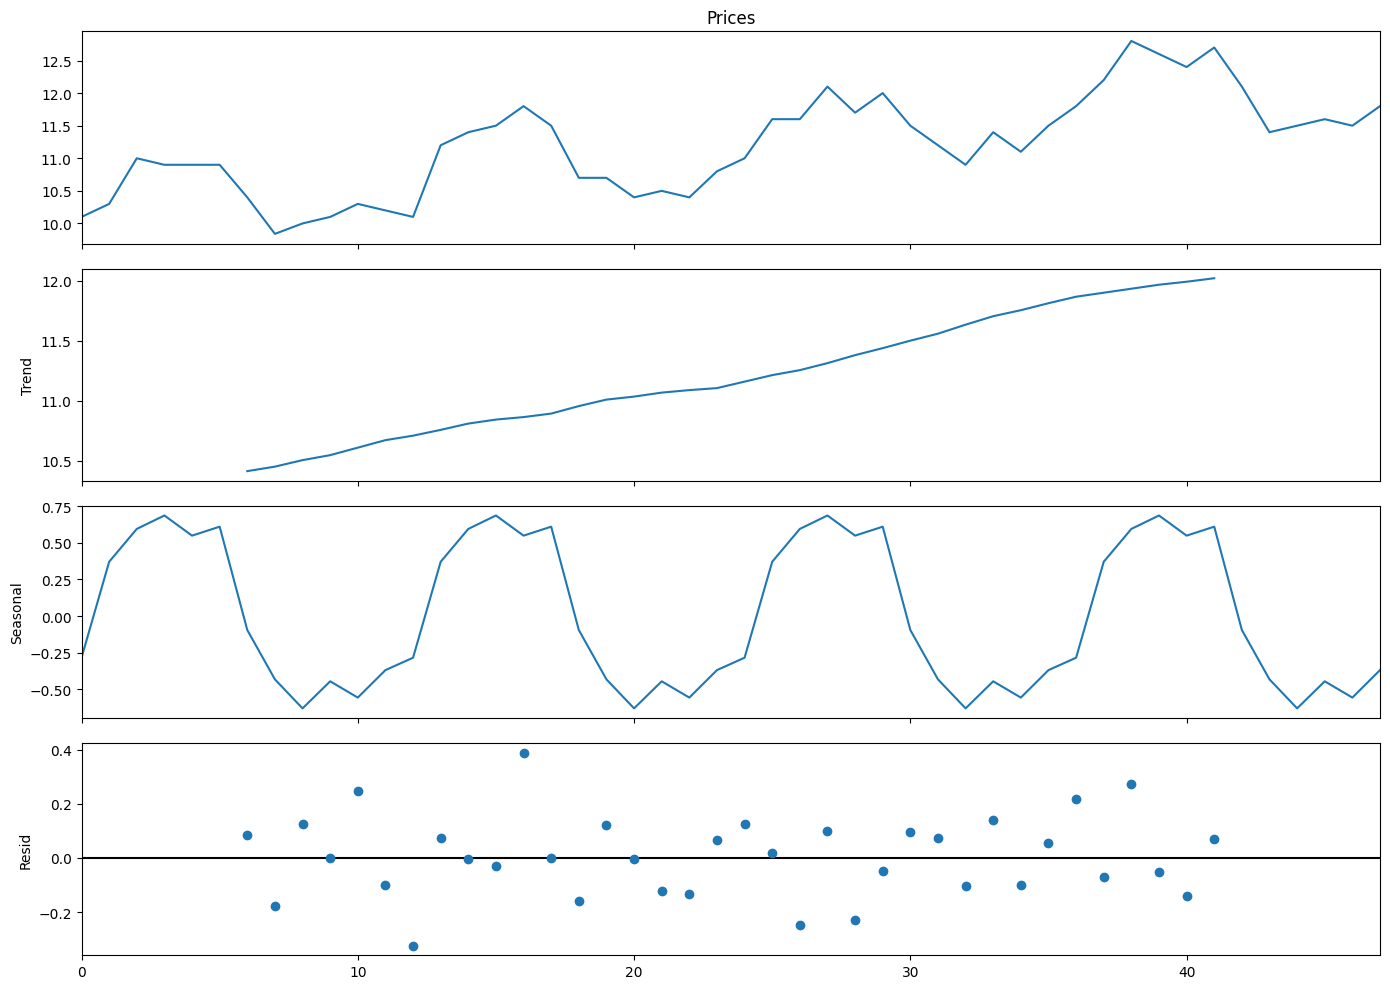

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the index as the index for decomposition
data.set_index('Dates')

# Decompose the time series
result = seasonal_decompose(data['Prices'], model='additive', period=12)

# Plot the decomposed components
fig = result.plot()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.show()

The decomposition reveals distinct patterns:

* **Trend**: There's a noticeable trend component, showing general price movements over time.
* **Seasonality**: The seasonal component clearly demonstrates yearly cyclical behavior, peaking during colder months which aligns with higher natural gas demand for heating.
* **Residuals**: The residuals, which capture irregular fluctuations not explained by the trend or seasonality, seem relatively small but do show some spikes.

To forecast future prices, I'll fit a model that combines a linear trend with a seasonal component. This model will then be used for extrapolating prices up to one year beyond the existing data. I'll use a combination of linear regression for the trend and sinusoidal functions to model the seasonal variation

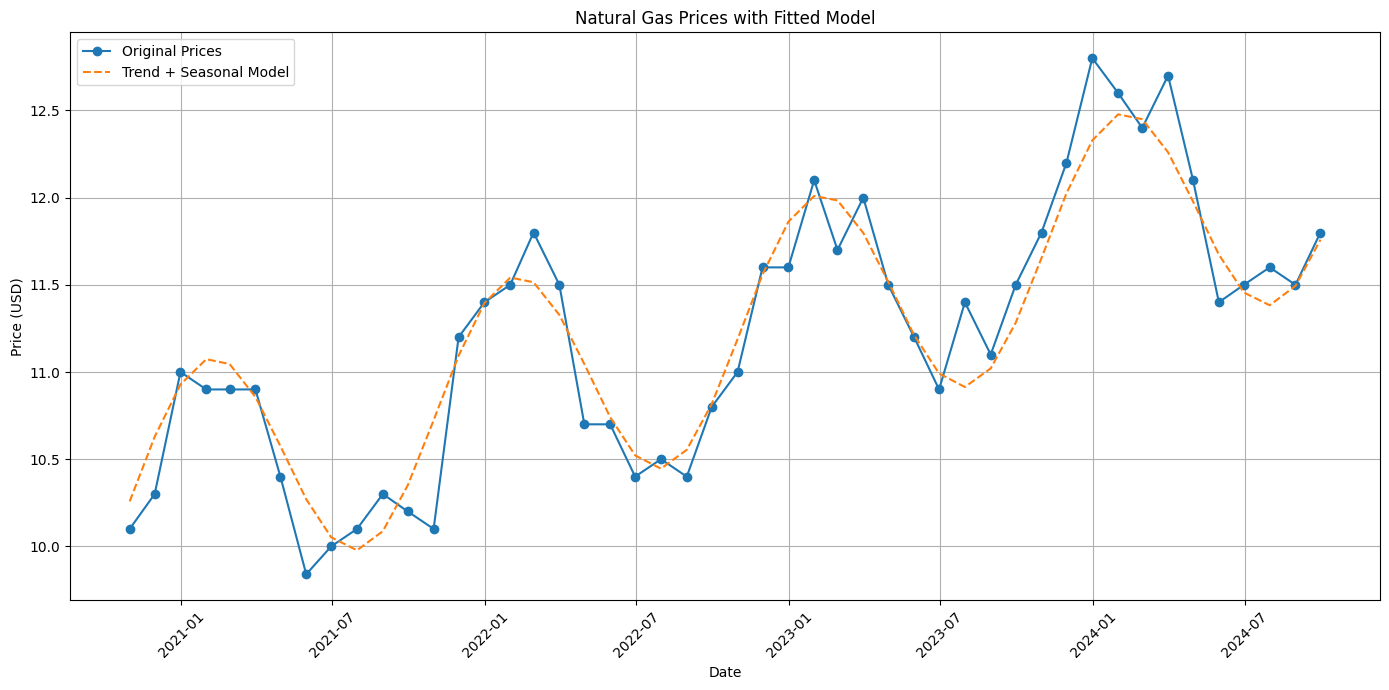

In [4]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare data for trend and seasonality modelling
data.reset_index(inplace=True)
data['time_index'] = (data['Dates'] - data['Dates'].min()).dt.days

# Fit a linear model for trend
model_trend = LinearRegression()
model_trend.fit(data[['time_index']], data['Prices'])

# Predict the trend component
data['trend'] = model_trend.predict(data[['time_index']])

# Extract seasonal component by removing trend from original prices
data['detrended'] = data['Prices'] - data['trend']

# Fit sinusoidal seasonal model
#Days in a year approximation for frequency
freq = 365.25
data['sin_time'] = np.sin(2 * np.pi * data['time_index'] / freq)
data['cos_time'] = np.cos(2 * np.pi * data['time_index'] / freq)

# Multiple linear regression to include both sine and cosine components
model_seasonal = LinearRegression(fit_intercept=False)
model_seasonal.fit(data[['sin_time', 'cos_time']], data['detrended'])

#Apply the full model to the data
data['seasonal_fit'] = model_seasonal.predict(data[['sin_time', 'cos_time']])
data['full_model'] = data['trend'] + data['seasonal_fit']

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(data['Dates'], data['Prices'], label='Original Prices', marker='o')
plt.plot(data['Dates'], data['full_model'], label='Trend + Seasonal Model', linestyle='--')
plt.title('Natural Gas Prices with Fitted Model')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The fitted model, which combines a linear trend with sinusoidal seasonal adjustments, appears to track the observed natural gas prices reasonably well. This model can now be used to interpolate and extrapolate prices for any date, including up to one year beyond the last date in our dataset.

In [5]:
from datetime import timedelta

def predict_price(date):
  # Convert input date to datetime if it's a string
  if isinstance(date, str):
    date = pd.to_datetime(date)

  # Calculate the time index from the start date
  start_date = data['Dates'].min()
  time_index = (date - start_date).days

  # Predict the trend component
  trend = model_trend.predict(np.array([[time_index]]))

  # Calculate seasonal components
  sin_time = np.sin(2 * np.pi * time_index / 365.25)
  cos_time = np.cos(2 * np.pi * time_index / 365.25)
  seasonal = model_seasonal.predict(np.array([[sin_time, cos_time]]))

  # Sum trend and seasonal components to get the full model prediction
  predicted_price = trend + seasonal
  return predicted_price[0]

In [6]:
# Test the function with a date within the dataset

test_date = ['2021-12-31']
predicted_price = [predict_price(date) for date in test_date]

predicted_price

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


[11.395327241926033]

For December 31, 2021, the predicted price is approximately $11.40.

To extrapolate natural gas prices for one year into the future beyond the existing data, we'll first determine the end date of our current dataset and then generate dates for the next year at monthly intervals. We'll use the predictive function to estimate prices for these future dates.

In [7]:
# Last date in the dataset
last_date = data['Dates'].max()

# Generate monthly dates for one year into the future
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=12, freq='M')

# Predict prices for these future dates
future_prices = [predict_price(date) for date in future_dates]

#Create a DataFrame to display future dates and their predicted prices
future_price_data = pd.DataFrame({
    'Dates': future_dates,
    'Predicted Price (USD)': future_prices
})

future_price_data

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

,Dates,Predicted Price (USD)
0,2024-10-31,12.131561
1,2024-11-30,12.502136
2,2024-12-31,12.802360
3,2025-01-31,12.947194
4,2025-02-28,12.919142
5,2025-03-31,12.730310
6,2025-04-30,12.448281
7,2025-05-31,12.143780
8,2025-06-30,11.925645
9,2025-07-31,11.851013


In [8]:
from datetime import date, timedelta

def price_contract(in_dates, in_prices, out_dates, out_prices, rate, storage_cost_rate, total_vol, injection_withdrawal_cost_rate):
    volume = 0
    cash_in = 0
    total_cost = 0
    last_date = min(min(in_dates), min(out_dates))

    # Ensure dates are sorted
    all_dates = sorted(set(in_dates + out_dates))

    for current_date in all_dates:
        if current_date in in_dates:
            idx = in_dates.index(current_date)
            if volume + rate <= total_vol:
                volume += rate
                purchase_cost = rate * in_prices[idx]
                injection_cost = rate * injection_withdrawal_cost_rate
                total_cost += purchase_cost + injection_cost
                print(f'Injected {rate} MMBtu of gas on {current_date} at ${in_prices[idx]}/MMBtu')
            else:
                print(f'Injection not possible on {current_date} due to insufficient storage space')

        if current_date in out_dates:
            idx = out_dates.index(current_date)
            if volume >= rate:
                volume -= rate
                sales_revenue = rate * out_prices[idx]
                withdrawal_cost = rate * injection_withdrawal_cost_rate
                cash_in += sales_revenue - withdrawal_cost
                print(f'Extracted {rate} MMBtu of gas on {current_date} at ${out_prices[idx]}/MMBtu')
            else:
                print(f'Extraction not possible on {current_date} due to insufficient gas volume')

    # Calculate storage costs over the entire period
    duration = (max(max(in_dates), max(out_dates)) - min(min(in_dates), min(out_dates))).days
    months = (duration // 30) + (1 if duration % 30 > 0 else 0)
    storage_cost = months * storage_cost_rate

    # Calculate the net contract value
    net_value = cash_in - total_cost - storage_cost
    return net_value

# Injection and withdrawal dates are closely aligned with prices varying slightly to see the contract value dynamics
in_dates_example = [date(2023, 1, 1), date(2023, 2, 1), date(2023, 3, 1), date(2023, 4, 1)]
in_prices_example = [2.0, 2.1, 2.05, 2.2]
out_dates_example = [date(2023, 1, 15), date(2023, 2, 15), date(2023, 3, 15), date(2023, 5, 1)]
out_prices_example = [2.5, 2.3, 2.4, 2.7]
rate_example = 1000000  # Reduced rate for injection and withdrawal
storage_cost_rate_example = 50000  # Reduced storage cost per month
total_vol_example = 2000000  # Reduced total storage volume
injection_withdrawal_cost_rate_example = 0.01  # Reduced injection/withdrawal cost rate

# Running the adjusted example
value_example = price_contract(
    in_dates_example, in_prices_example,
    out_dates_example, out_prices_example,
    rate_example, storage_cost_rate_example,
    total_vol_example, injection_withdrawal_cost_rate_example
)
value_example

Injected 1000000 MMBtu of gas on 2023-01-01 at $2.0/MMBtu
Extracted 1000000 MMBtu of gas on 2023-01-15 at $2.5/MMBtu
Injected 1000000 MMBtu of gas on 2023-02-01 at $2.1/MMBtu
Extracted 1000000 MMBtu of gas on 2023-02-15 at $2.3/MMBtu
Injected 1000000 MMBtu of gas on 2023-03-01 at $2.05/MMBtu
Extracted 1000000 MMBtu of gas on 2023-03-15 at $2.4/MMBtu
Injected 1000000 MMBtu of gas on 2023-04-01 at $2.2/MMBtu
Extracted 1000000 MMBtu of gas on 2023-05-01 at $2.7/MMBtu


1270000.0